# 🤖 Tutorial: Introduction to Using BERT Models in Python  
> *A hands-on guide to getting started with transformer-based language models*  
Instructor: Yasmine Houri (yasmine.houri@ensae.fr)

Sources and inspirations:
- https://www.tensorflow.org/text/tutorials/classify_text_with_bert
- https://huggingface.co/blog/bert-101#7-how-to-get-started-using-bert
- https://colab.research.google.com/drive/1YtTqwkwaqV2n56NC8xerflt95Cjyd4NE?usp=sharing
- https://medium.com/@sandeep.ai/text-classification-using-hugging-face-fine-tuning-43c7416b049b
- https://www.tensorflow.org/tfmodels/nlp/fine_tune_bert
- https://colab.research.google.com/github/DerwenAI/spaCy_tuTorial/blob/master/BERT_Fine_Tuning.ipynb#scrollTo=BJR6t_gCQe_x

## What is BERT?

**BERT** (short for *Bidirectional Encoder Representations from Transformers*) is a machine learning model designed for natural language processing (NLP). Developed in 2018 by researchers at Google AI Language, BERT marked a major breakthrough in the field. Unlike earlier state-of-the-art models, which were typically tailored for specific tasks, BERT's transformer-based architecture enabled unprecedented performance across a wide range of NLP applications using a unified, pre-trained model.

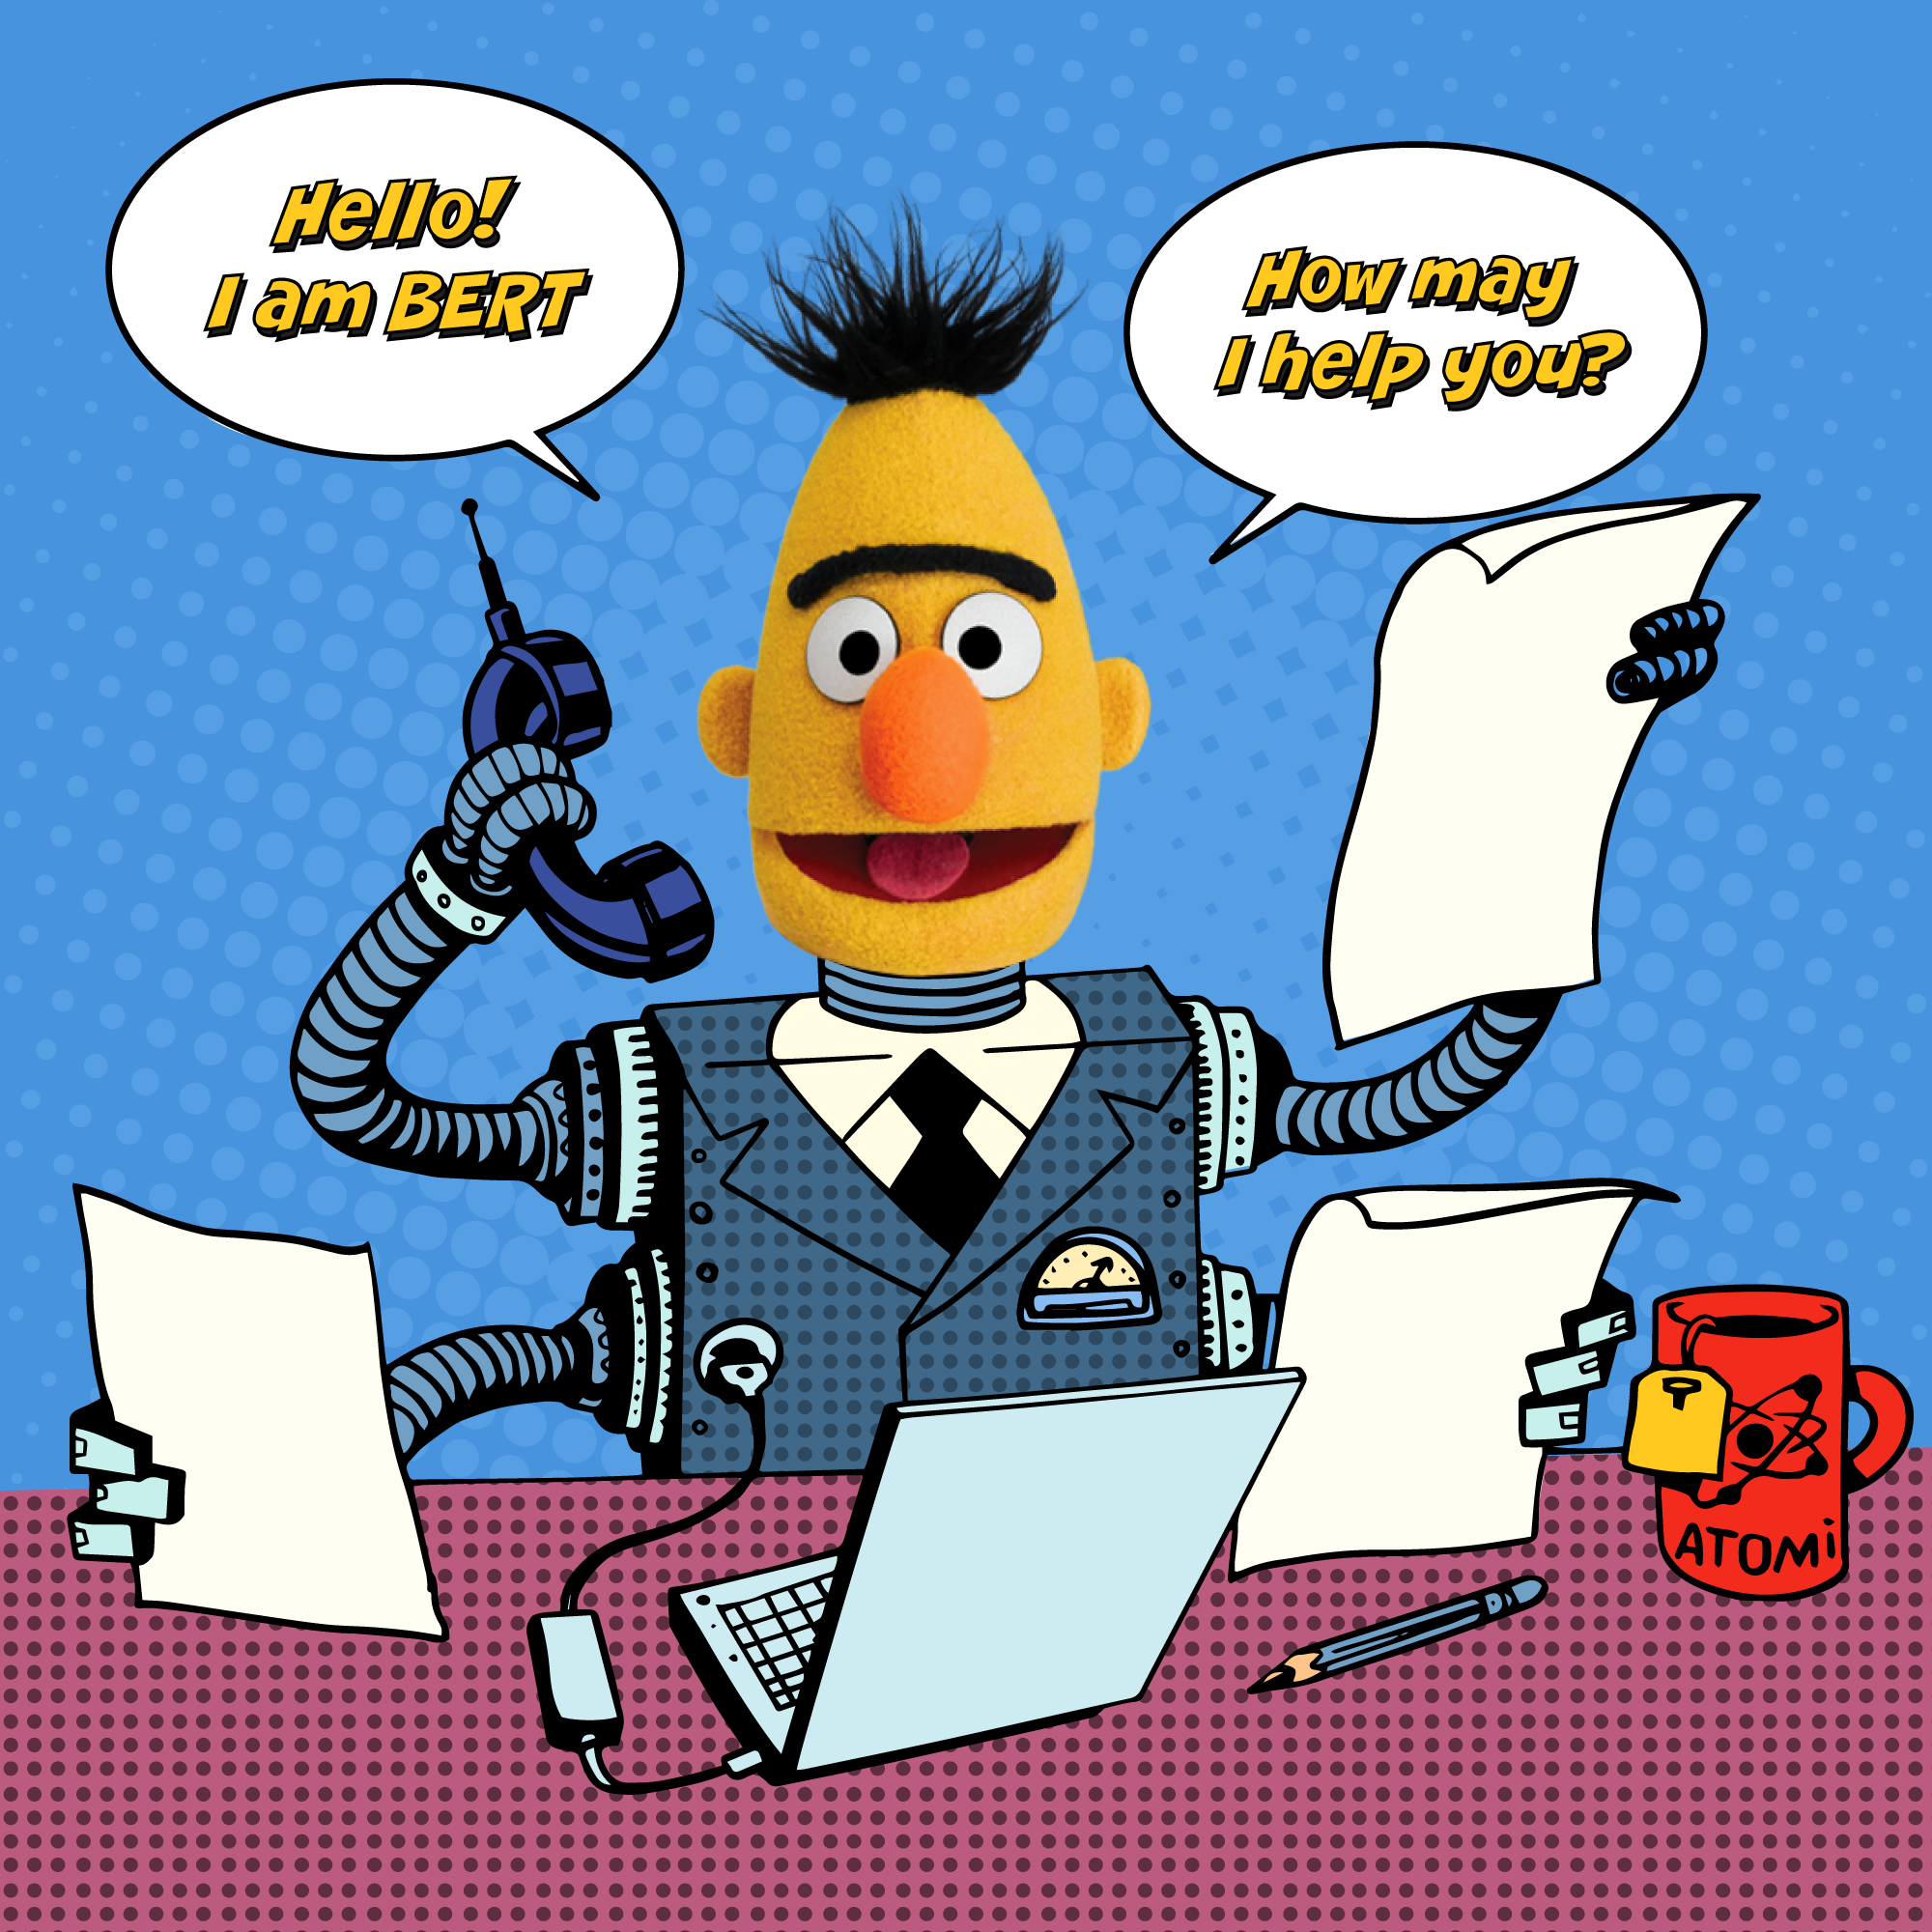

BERT can be used for NLP tasks including (but not restricted to):  
- sentiment analysis;
- question answering;
- text prediction;
- text generation;
- text summarization;
- etc.

In practice, BERT models are typically pre-trained on large corpora of text and then fine-tuned for specific downstream tasks. You will almost never need to build or train a BERT model from scratch, as pre-trained models are widely available and can be adapted with relatively little data.

In this notebook, you will learn how to prepare text data for BERT and fine-tune pre-trained models for common NLP tasks. We’ll also take a brief look at how BERT is originally trained, and explore some of its recent variants and developments in the transformer ecosystem.

> Note: In this notebook, we will be using the Hugging Face [pipeline class](https://huggingface.co/docs/transformers/main_classes/pipelines) to load and run pre-trained models with only a few lines of code. Get ready to put your skills from the dedicated tutorial into practice!

## Getting Started: BERT Tokenization

In [ ]:
# Install transformers (uncomment if necessary)

# !pip install transformers
# !pip install tf-keras

Like any machine learning model, BERT requires input text to be broken down into smaller, manageable pieces known as *tokens*. This process is called *tokenization*. Tokenization converts raw text into units that the model can understand and process.

When you use a pre-trained tokenizer such as [```BertTokenizer```](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertTokenizer) or [```AutoTokenizer```](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer), it performs the following tasks:
1. Sub-word tokenization (using [WordPiece](https://huggingface.co/learn/llm-course/en/chapter6/6))
2. Addind special tokens such as ```[CLS]``` and ```[SEP]```
3. Generate token IDs (token row index in the embedding matrix)
> Note: Padding and truncation are not applied unless you explicitly pass padding=... and truncation=True to the tokenizer. We will further develop these notions in the "fine-tuning" section below.

In essence the tokenizer is a function that matches word sequences with their row indices in the embedding matrix.  



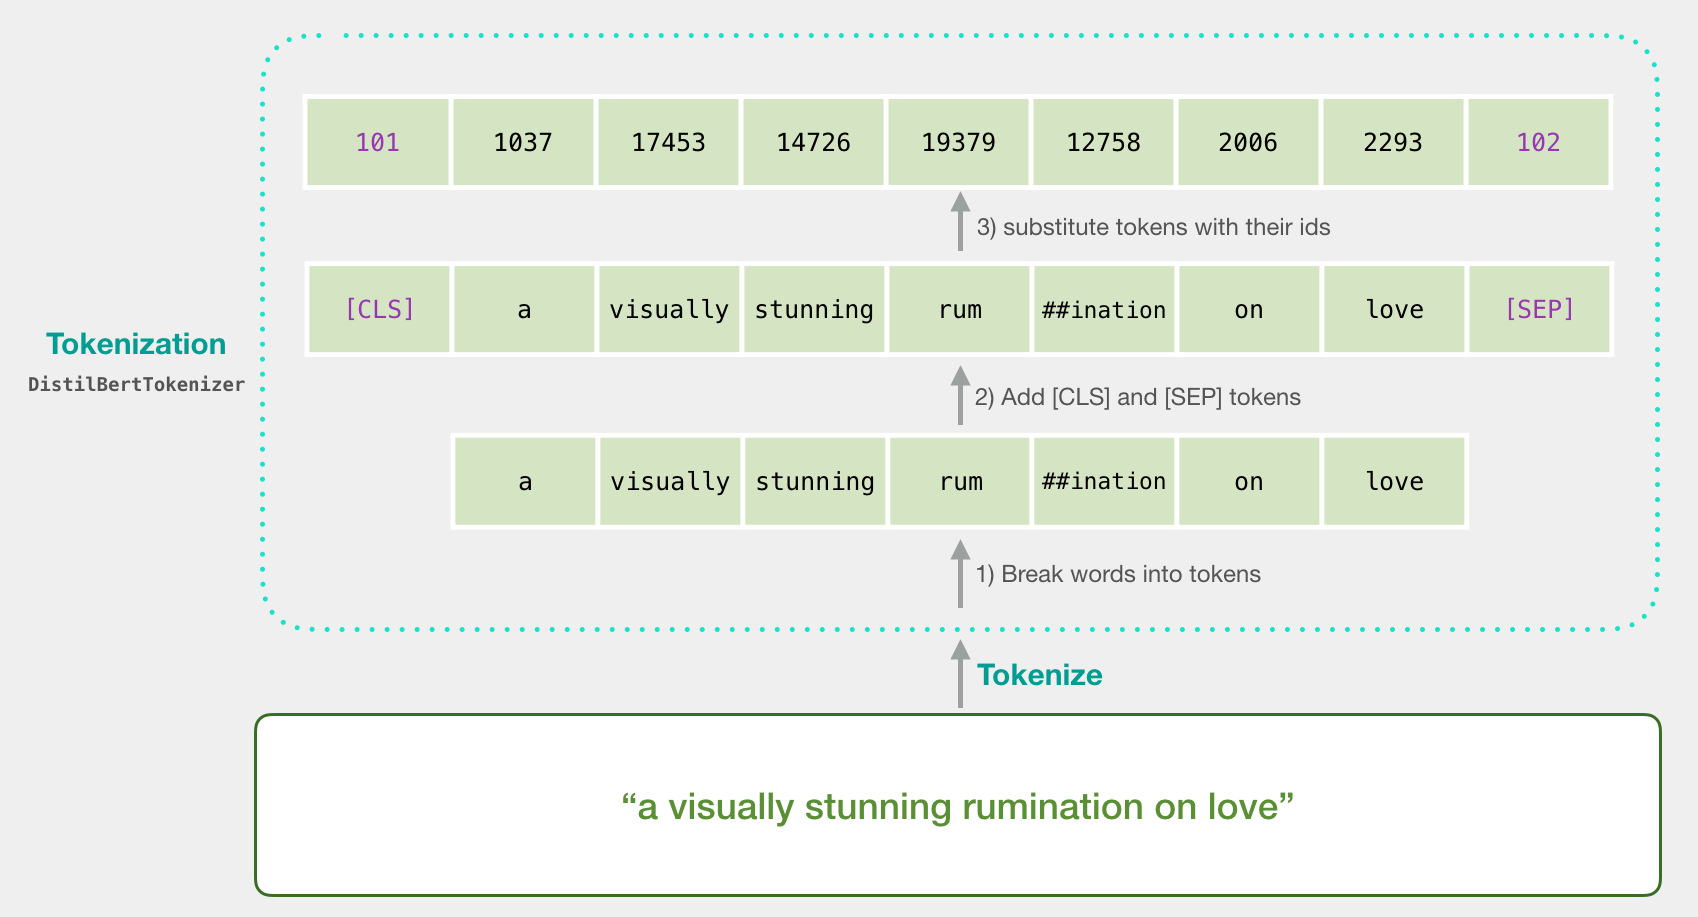

Let's try it out!

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

text = "The 2025 Paris edition of the Summer Institute in Computational Social Science is such a blast!"
encoded = tokenizer(text, return_tensors="pt")

print(encoded)


{'input_ids': tensor([[  101,  1996, 16798,  2629,  3000,  3179,  1997,  1996,  2621,  2820,
          1999, 15078,  2591,  2671,  2003,  2107,  1037,  8479,   999,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


This code returns a dictionary containing three key elements:

1. **`input_ids`**:  
   A list of token IDs representing the input text after tokenization.

2. **`token_type_ids`**:  
   A sequence indicating the sentence each token belongs to —  
   `0` for tokens in the first sentence,  
   `1` for tokens in the second sentence.
   > Note: When tokenizing more than two sentences as a single string (without explicitly splitting them), the tokenizer assigns all tokens to segment 0. This field is primarily used for tasks that involve sentence pairs, such as next sentence prediction.

3. **`attention_mask`**:  
   A binary mask indicating which tokens should be attended to (`1`) and which should be ignored (`0`).  
   This helps the model ignore padding tokens or truncated parts of the input.


The code below illustrates how ```'token_type_ids'``` vary when tokenizing a pair of sentences.

In [ ]:
text = ["This is the 2025 Paris edition of the Summer Institute in Computational Social Science.", "It is such a blast!"]
encoded = tokenizer(text[0], text[1], return_tensors="pt")

print(encoded)


{'input_ids': tensor([[  101,  2023,  2003,  1996, 16798,  2629,  3000,  3179,  1997,  1996,
          2621,  2820,  1999, 15078,  2591,  2671,  1012,   102,  2009,  2003,
          2107,  1037,  8479,   999,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
         1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1]])}


## How to Use BERT with the Hugging Face Pipeline Class

Missing word prediction

In [ ]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='bert-base-uncased')
masked_sentence = "Large Language Models [MASK] overthrow humans."
unmasker(masked_sentence)

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'c

[{'score': 0.5115230083465576,
  'token': 2064,
  'token_str': 'can',
  'sequence': 'large language models can overthrow humans.'},
 {'score': 0.16783498227596283,
  'token': 2000,
  'token_str': 'to',
  'sequence': 'large language models to overthrow humans.'},
 {'score': 0.09799675643444061,
  'token': 2071,
  'token_str': 'could',
  'sequence': 'large language models could overthrow humans.'},
 {'score': 0.05341845378279686,
  'token': 2089,
  'token_str': 'may',
  'sequence': 'large language models may overthrow humans.'},
 {'score': 0.04543047770857811,
  'token': 2008,
  'token_str': 'that',
  'sequence': 'large language models that overthrow humans.'}]

Text classification

In [ ]:
classifier = pipeline('text-classification', model='distilbert-base-uncased-finetuned-sst-2-english')
sentence_1 = "This tutorial is fascinating!"
sentence_2 = "This tutorial is boring."
result_1 = classifier(sentence_1)
result_2 = classifier(sentence_2)
print(
    f"Predicted sentiment for {sentence_1}: {result_1}\n"
    f"Predicted sentiment for {sentence_2}: {result_2}"
)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Predicted sentiment for This tutorial is fascinating!: [{'label': 'POSITIVE', 'score': 0.9997909665107727}]
Predicted sentiment for This tutorial is boring.: [{'label': 'NEGATIVE', 'score': 0.9997991919517517}]


Question Answering
> <em style="font-size: 90%;">Source: <a href="https://huggingface.co/SRDdev/QABERT-small" target="_blank">https://huggingface.co/SRDdev/QABERT-small</a></em>

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

QAtokenizer = AutoTokenizer.from_pretrained("SRDdev/QABERT-small")

QAmodel = AutoModelForQuestionAnswering.from_pretrained("SRDdev/QABERT-small")

context = """
Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question-answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune
a model on a SQuAD task, you may leverage the examples/pytorch/question-answering/run_squad.py script.
"""

ask = pipeline("question-answering", model= QAmodel , tokenizer = QAtokenizer)

result = ask(question="What is a good example of a question answering dataset?", context=context)

print(f"Answer: '{result['answer']}'")


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Answer: 'SQuAD dataset,'


## 🧪 Your Turn: Experiment with BERT and 🤗 Pipelines

Choose a BERT-based model from the Hugging Face Hub and use it with the `pipeline` class to perform a task of your choice.

You can explore tasks like:
- Sentiment analysis
- Named entity recognition
- Text classification
- Masked word prediction
- Anything else you're curious about!

Use any sentence or text snippet you'd like, and display the output.


## Fine-tuning BERT for Downstream Tasks

> What is fine-tuning?

**Fine-tuning** is the process of further training a pre-trained neural network on new, task-specific data. It is a form of **transfer learning**, a machine learning technique where knowledge gained from solving one problem is leveraged to solve a related, often more specialized, task. By building on the representations already learned by the model, fine-tuning improves performance and generalization on the new dataset while requiring less data and computational resources than training from scratch.

> Why is it useful?

The release of pre-trained language models like BERT in 2018 marked a major breakthrough in natural language processing. These models can be readily fine-tuned to achieve state-of-the-art results across a wide range of tasks, fundamentally changing how NLP systems are developed. Instead of learning all parameters from scratch, scientists can easily reuse the rich linguistic representations encoded in the pre-trained layers and adapt them to new tasks.

Because models like BERT already capture extensive language structure, fine-tuning requires far less training time and data. Despite the smaller datasets involved, fine-tuned models consistently deliver top performance on a wide range of NLP tasks.


In this section, we will fine-tune BERT on a specific case of text classification. We will use the [Corpus of Linguistic Acceptability (CoLA)](https://nyu-mll.github.io/CoLA/) a set of sentences labeled as grammatically correct or incorrect.

To perform the analyses, you will need to download the dataset from the following address: https://nyu-mll.github.io/CoLA/ .


### Format the input data

In [ ]:
# !pip install pytorch_pretrained_bert

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv(r"cola_public_1.1\cola_public\raw\in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.head()

,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"Our friends won't buy this analysis, let alone..."
1,gj04,1,NaN,One more pseudo generalization and I'm giving up.
2,gj04,1,NaN,One more pseudo generalization or I'm giving up.
3,gj04,1,NaN,"The more we study verbs, the crazier they get."
4,gj04,1,NaN,Day by day the facts are getting murkier.


The dataset contains 4 columns which we manually renamed when loading the dataset. Columns are described by the authors as follows:  
- Column 1:	the code representing the source of the sentence.
- Column 2:	the acceptability judgment label (0=unacceptable, 1=acceptable).
- Column 3:	the acceptability judgment as originally notated by the author.
- Column 4:	the sentence.

In [ ]:
# Print 'unacceptable sentences'
df[df['label']==0]['sentence']

18                                    They drank the pub.
20                               The professor talked us.
22                                   We yelled ourselves.
23                                We yelled Harry hoarse.
25                                 Harry coughed himself.
                              ...                        
8531                          Anson believed to be happy.
8539                 Anson left before Jenny saw himself.
8545    Anson thought that himself was going to the club.
8546                     Poseidon appears to own a dragon
8547                       Digitize is my happiest memory
Name: sentence, Length: 2528, dtype: object

Now is the time to 😉 transfer 😉 your tokenizing skills!  
For the sake of simplicity, we will use the same tokenizer as above to process this new dataset. Alternatively, you could initialize a different one with  
```tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)```.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

tokenized_texts = [tokenizer.tokenize(sent) for sent in df['sentence']]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])


Tokenize the first sentence:
['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']


Notice the difference with the original sentence:

In [ ]:
df.loc[0,"sentence"]

"Our friends won't buy this analysis, let alone the next one we propose."

Previously, when we learned to tokenize text for BERT, we did not elaborate on padding and truncation.  
In fact, during training, BERT requires input sentences to be of same length. To address this, we first need to choose a desired length, and then format the encoded sentences as follows:
- sentences shorter than the maximum desired length will be filled (**padded**) with zeroes at their end until they reach the desired length,
- sentences longer than the maximum desired length will be truncated at the end as well, discaarding any text that comes after the desired length.

In [ ]:
# Set the maximum sequence length
MAX_LEN = 128

# Tokenize, pad, truncate, and return attention masks — all in one step
encodings = tokenizer(
    list(df['sentence']),                         # A list of input strings
    max_length=MAX_LEN,           # Maximum length of the sequences
    padding='max_length',         # Pad to MAX_LEN
    truncation=True,              # Truncate longer sequences
    return_tensors='pt',          # Return PyTorch tensors
    return_attention_mask=True    # Include attention masks
)

input_ids = encodings['input_ids']
attention_masks = encodings['attention_mask']


In [ ]:
encodings['input_ids'][0]

tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [ ]:
input_ids = encodings['input_ids']
attention_masks = encodings['attention_mask']

In [ ]:
labels = torch.tensor(df.label.values)

# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [ ]:
torch.unique(labels)

tensor([0, 1])

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

C:\Users\167266\AppData\Local\Temp\ipykernel_10216\1580927517.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(train_inputs)
C:\Users\167266\AppData\Local\Temp\ipykernel_10216\1580927517.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_inputs = torch.tensor(validation_inputs)
C:\Users\167266\AppData\Local\Temp\ipykernel_10216\1580927517.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels)
C:\Users\167266\AppData\Local\Temp\ipykernel_10216\1580927517.py:6

In [ ]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


### Train the model

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=Fa

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    print("✅ Using GPU for inference.")
else:
    print("⚠️ GPU not available. Using CPU instead.")


✅ Using GPU for inference.


In [ ]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):


  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()


    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))


  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]c:\Users\167266\nlp\Lib\site-packages\pytorch_pretrained_bert\optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\python_arg_parser.cpp:1661.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.5791850496871838


Epoch:  25%|██▌       | 1/4 [01:56<05:50, 116.94s/it]

Validation Accuracy: 0.7665895061728395
Train loss: 0.384772145587379


Epoch:  50%|█████     | 2/4 [03:54<03:54, 117.36s/it]

Validation Accuracy: 0.7881944444444444
Train loss: 0.1947310448805821


Epoch:  75%|███████▌  | 3/4 [05:52<01:57, 117.76s/it]

Validation Accuracy: 0.8290895061728395
Train loss: 0.0991325162242928


Epoch: 100%|██████████| 4/4 [07:51<00:00, 117.96s/it]

Validation Accuracy: 0.8252314814814815


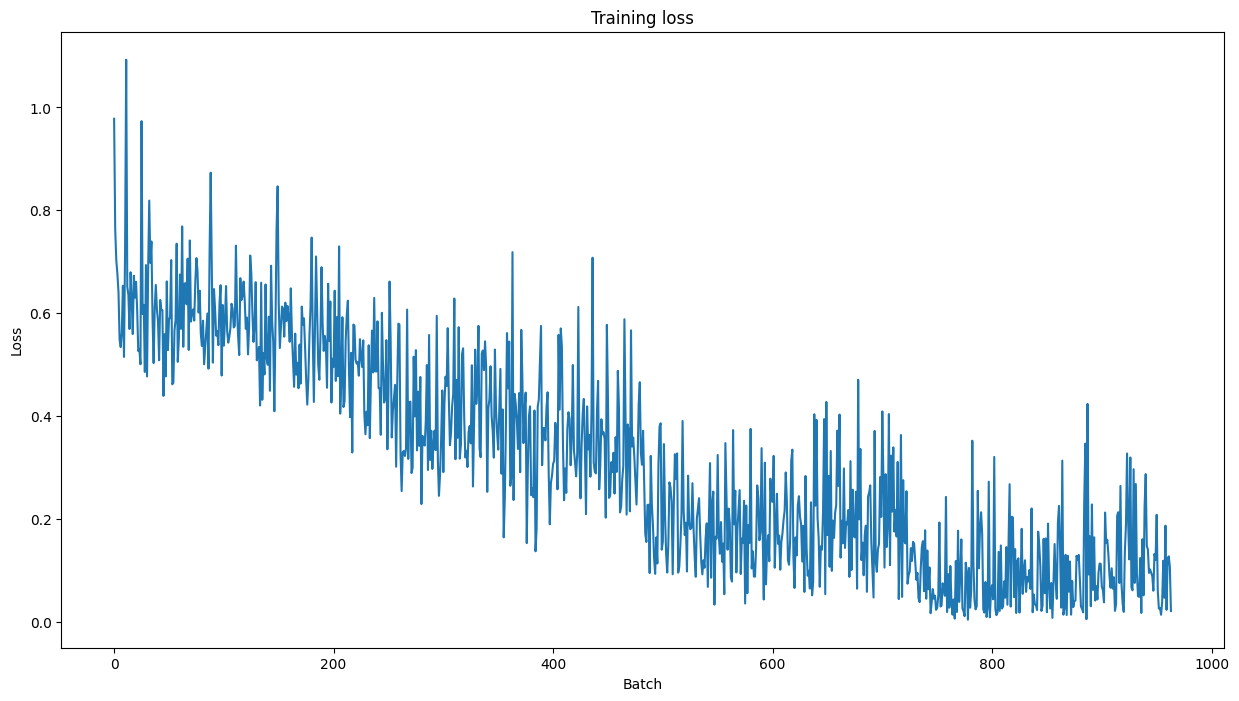

In [ ]:
# Training evaluation

plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

### Test the fine-tuned model on out-of-sample observations

In [ ]:
df_test = pd.read_csv(r"cola_public_1.1\cola_public\raw\out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [ ]:
# Tokenize
encodings = tokenizer(list(df_test['sentence']), truncation=True, padding=True, max_length=128, return_tensors='pt')
dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'])

# Load
dataloader = DataLoader(dataset, batch_size=32)

# Predict
model.eval()
all_preds = []

for batch in dataloader:
    input_ids, attention_mask = tuple(t.to(device) for t in batch)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs  # shape: (batch_size, 2) if num_labels=2
        preds = torch.argmax(logits, dim=1)  # (batch_size,)
        all_preds.extend(preds.cpu().numpy())

# Add to DataFrame
df_test["pred_labels"] = all_preds


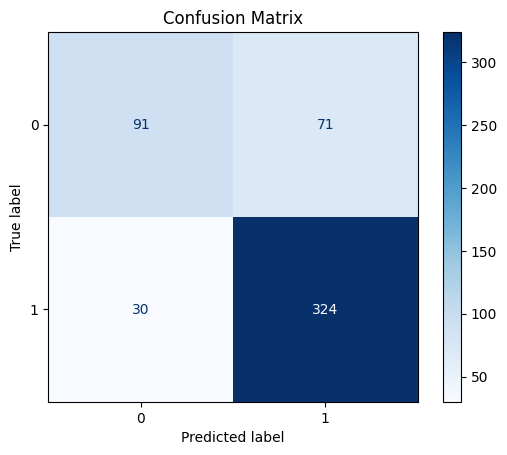

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ground truth labels
true_labels = df_test["label"].values   # or df_test.label if the column is named 'label'

# Predicted labels
pred_labels = df_test["pred_labels"].values

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# True and predicted labels
true_labels = df_test["label"].values
pred_labels = df_test["pred_labels"].values

# Print classification report
print("📊 Classification Report:")
print(classification_report(true_labels, pred_labels, digits=4))

# Print overall accuracy
print("✅ Accuracy:", accuracy_score(true_labels, pred_labels))


📊 Classification Report:
              precision    recall  f1-score   support

           0     0.7521    0.5617    0.6431       162
           1     0.8203    0.9153    0.8652       354

    accuracy                         0.8043       516
   macro avg     0.7862    0.7385    0.7541       516
weighted avg     0.7988    0.8043    0.7954       516

✅ Accuracy: 0.8042635658914729


Now the model is up and running! Let's try it on custom sentences.

In [ ]:
sentences = ['Today is the first day of the rest of your life.', 'I went yesterday ice-cream.']

# Tokenize
encodings = tokenizer(sentences, truncation=True, padding=True, max_length=128, return_tensors='pt')
dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'])

# Load
dataloader = DataLoader(dataset, batch_size=32)

# Predict
model.eval()
all_preds = []

for batch in dataloader:
    input_ids, attention_mask = tuple(t.to(device) for t in batch)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs  # shape: (batch_size, 2) if num_labels=2
        preds = torch.argmax(logits, dim=1)  # (batch_size,)
        all_preds.extend(preds.cpu().numpy())


In [ ]:
all_preds

[np.int64(1), np.int64(0)]